# Testis Replicate 3 1k UMI Cutoff

In [1]:
options(repr.plot.width=10, repr.plot.height=10)

In [2]:
DATA <- '../output/testis_cell_selection/2018-03-29_1k_umi_dump_data_testis3_raw_counts.tsv'
OUTDIR <- '../output/testis3_scRNAseq_umi1k'
dir.create(OUTDIR, showWarnings=FALSE)

REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')
NAME <- 'Testis1'

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [3]:
source('../lib/seurat.R')

In [4]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
dat <- read.table(DATA, header=TRUE, row.names='FBgn')

In [6]:
dim(dat)

[1] 17473 13983

In [7]:
paste('The minimum number of expressed genes in this dataset is:', min(colSums(dat > 0)))

[1] "The minimum number of expressed genes in this dataset is: 280"

In [8]:
# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). 
sobj <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes=200, project = NAME)
nCells <- dim(sobj@meta.data)[1]

# calculate the percent genes on chrom M
mask <- row.names(sobj@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj@raw.data[mask, ]/Matrix::colSums(sobj@raw.data)) * 100
sobj <- AddMetaData(object = sobj, metadata = percent.mito, col.name = "percent_mito")

In [9]:
nCells

[1] 13983

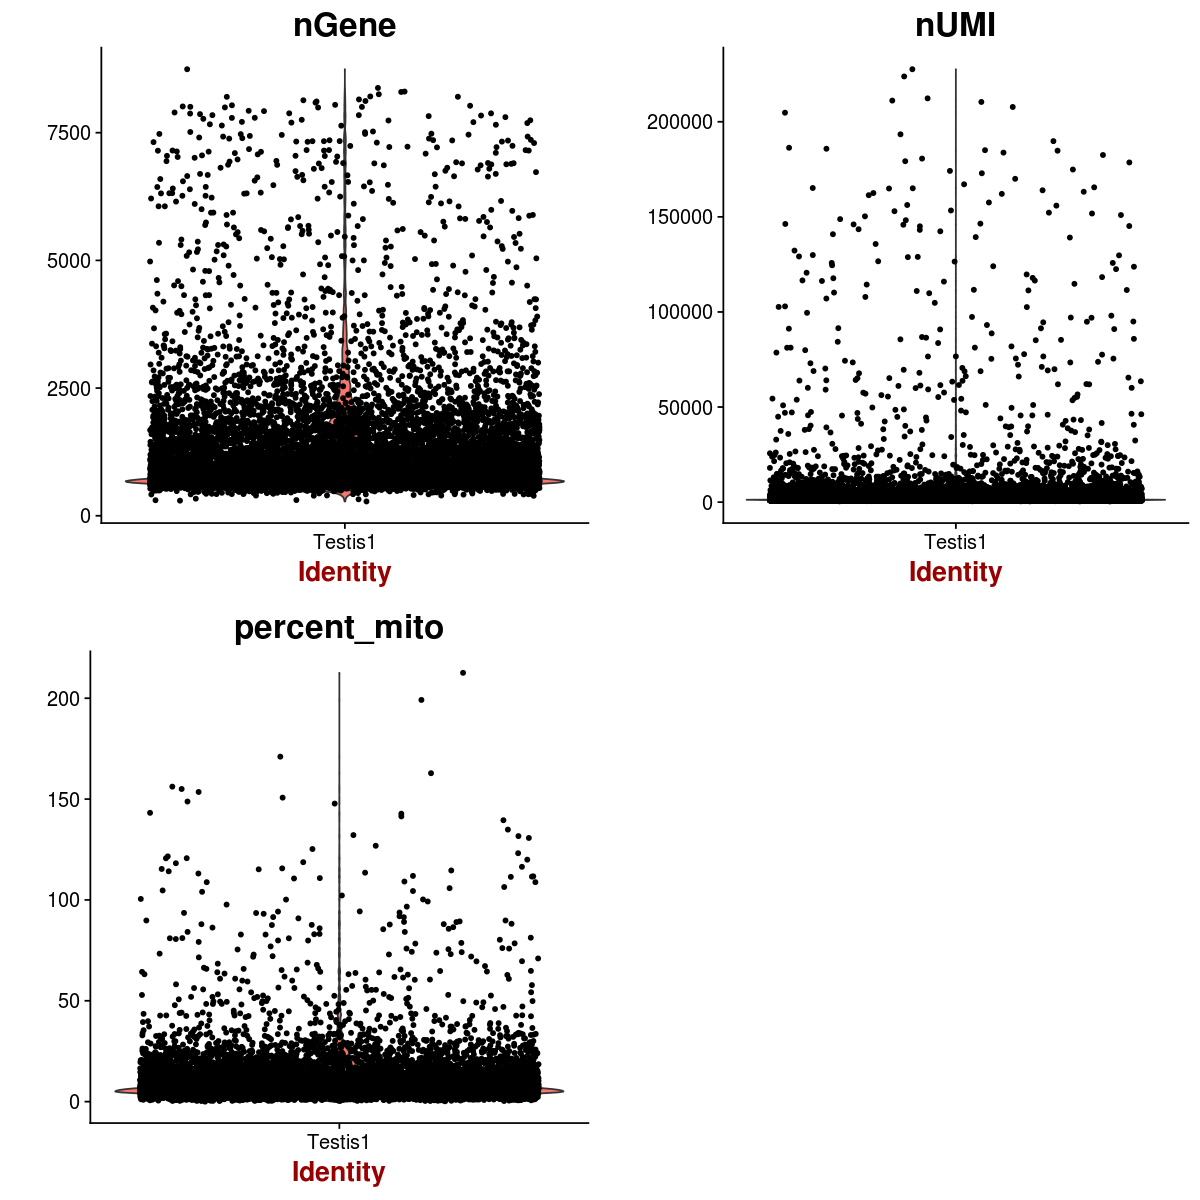

In [10]:
VlnPlot(object = sobj, features.plot = c('nGene', 'nUMI', 'percent_mito'), nCol = 2)

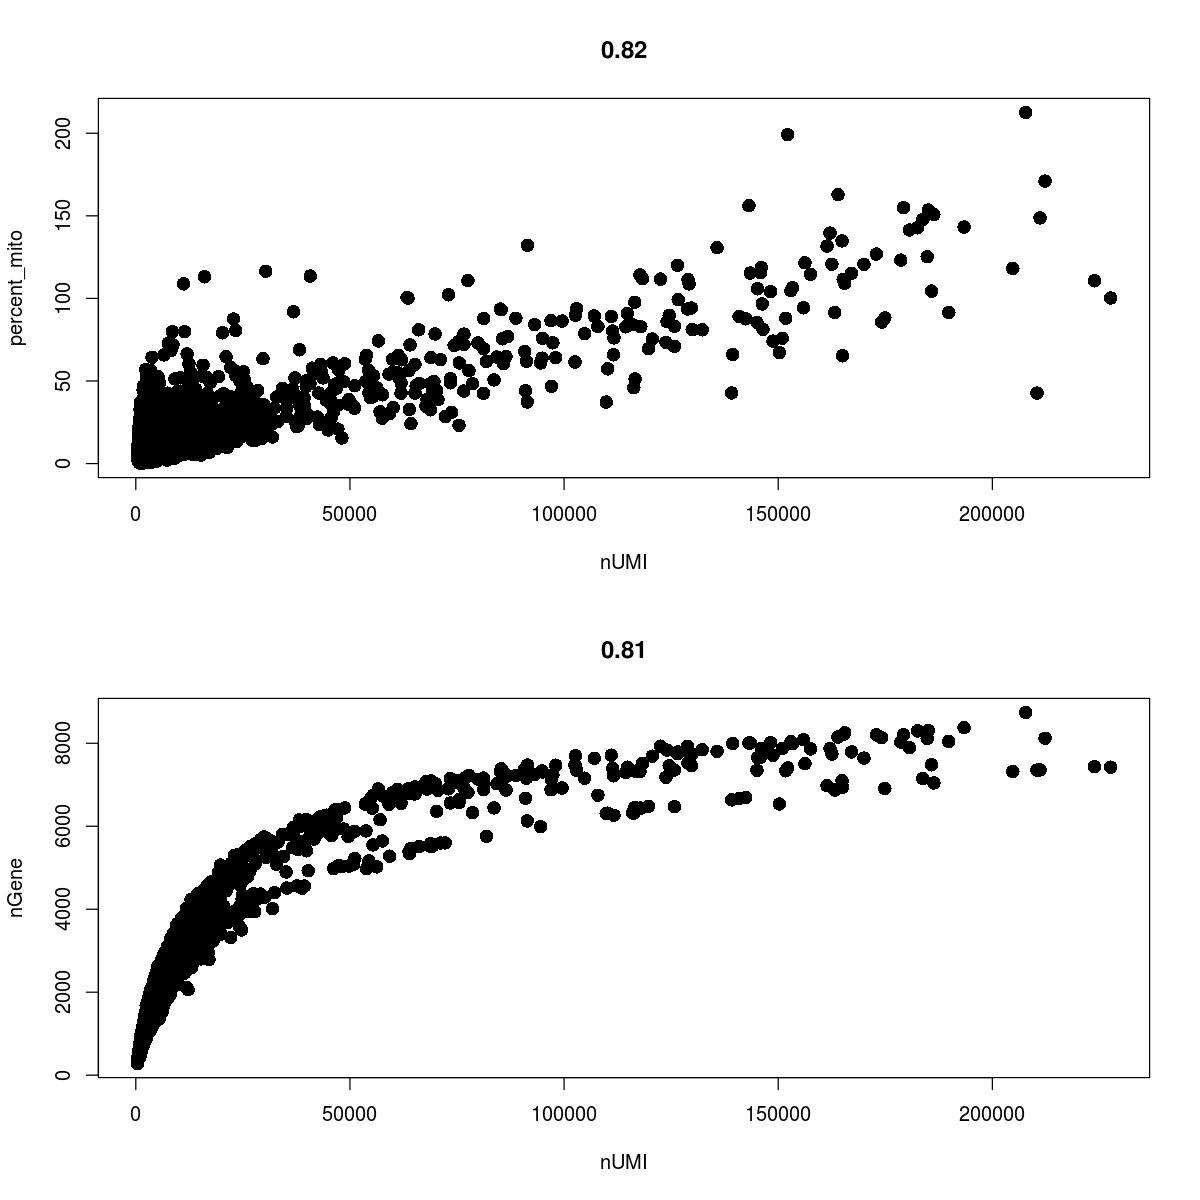

In [11]:
par(mfrow = c(2, 1))
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'percent_mito')
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'nGene')

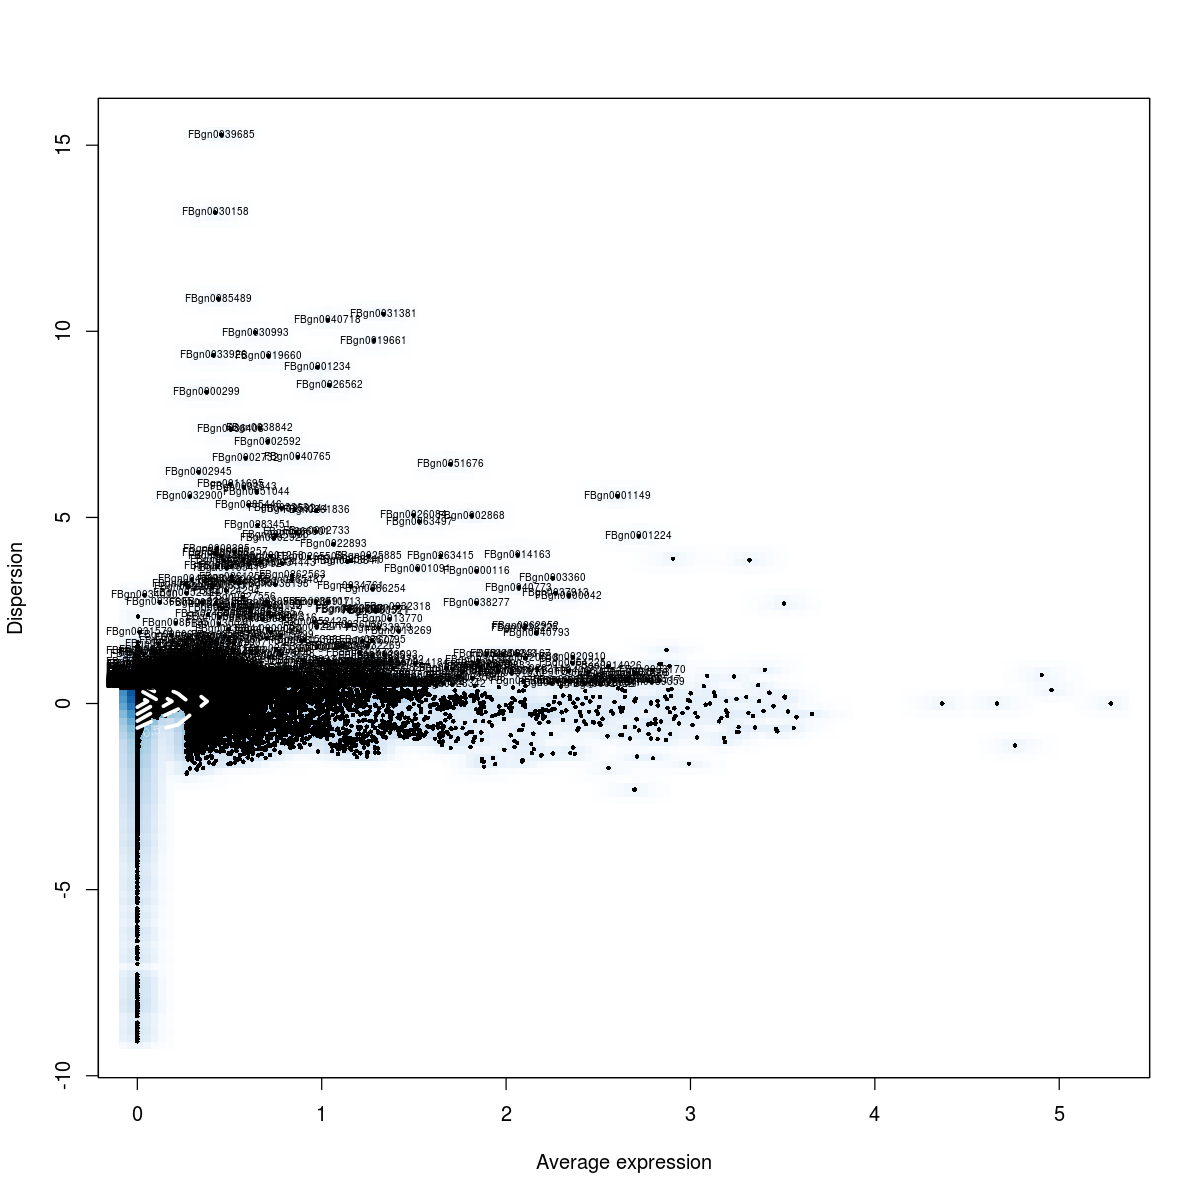

In [12]:
sobj <- NormalizeData(object = sobj, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj <- FindVariableGenes(object = sobj, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf
                          )

In [13]:
length(x = sobj@var.genes)

[1] 1082

In [14]:
sobj <- ScaleData(object = sobj, vars.to.regress = c("nUMI"), display.progress = F)

In [ ]:
### Perform linear dimensional reduction
sobj <- RunPCA(object = sobj, pc.genes = sobj@var.genes, do.print = FALSE, pcs.print = 1:5, genes.print = 5, pcs.compute = 100)

In [ ]:
PrintPCA(object = sobj, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

In [ ]:
VizPCA(object = sobj, pcs.use = 1:3)

In [ ]:
PCAPlot(object = sobj, dim.1 = 1, dim.2 = 2)

In [ ]:
# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
sobj <- ProjectPCA(object = sobj, do.print = F)

In [ ]:
PCElbowPlot(object = sobj, num.pc=30)

In [ ]:
sobj <- JackStraw(object = sobj, num.replicate = 100, do.print = FALSE, num.pc = 60)

In [ ]:
options(repr.plot.width=10, repr.plot.height=40)
JackStrawPlot(object = sobj, nCol = 4, PCs = 1:60)
options(repr.plot.width=10, repr.plot.height=10)

In [ ]:
sobj <- FindClusters(
    object = sobj, 
    reduction.type = "pca", 
    dims.use = 1:20, 
    resolution = c(0.4, 0.6, 1.0, 1.2, 1.4),
    print.output = 0, 
    save.SNN = TRUE, 
)
PrintFindClustersParams(object = sobj)

In [ ]:
### Run Non-linear dimensional reduction (tSNE)
sobj <- RunTSNE(object = sobj, dims.use = 1:22, do.fast = TRUE)

In [ ]:
TSNEPlot(object = sobj, group.by='res.0.4')

In [ ]:
TSNEPlot(object = sobj, group.by='res.0.6')

In [ ]:
TSNEPlot(object = sobj, group.by='res.1')

In [ ]:
TSNEPlot(object = sobj, group.by='res.1.2')

In [ ]:
TSNEPlot(object = sobj, group.by='res.1.4')

In [ ]:
dump_seurat(object = sobj, dir = OUTDIR)

In [ ]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj <- SetAllIdent(sobj, id = name)
    markers <- FindAllMarkers(object = sobj, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}